## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data
from src.utils import _torch_plot_ppds as plot_ppds

from src.attacks.distr_attacks import fgsm_attack, mlmc_attack, mlmc_gradient_estimator, kl_div, kl_to_appd

import numpy as np
import torch
from torch.optim import SGD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
X, y = get_toy_data()

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [5]:
# Model for which we know the true gradient
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [6]:
torch.inverse(model.lam)

tensor([[ 0.4148, -0.4224],
        [-0.4224,  0.4352]])

## APPD = N(mu, 2*sigma)

### Check gradient

In [7]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, np.sqrt(2) * std)
x_adv = x.clone().detach().requires_grad_(True)  
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = kl_to_appd(model.mu, model.lam, model.sigma2, x_adv, x.T @ model.mu, 2 * std ** 2)
kl.backward()
real_grad = x_adv.grad.clone().detach()

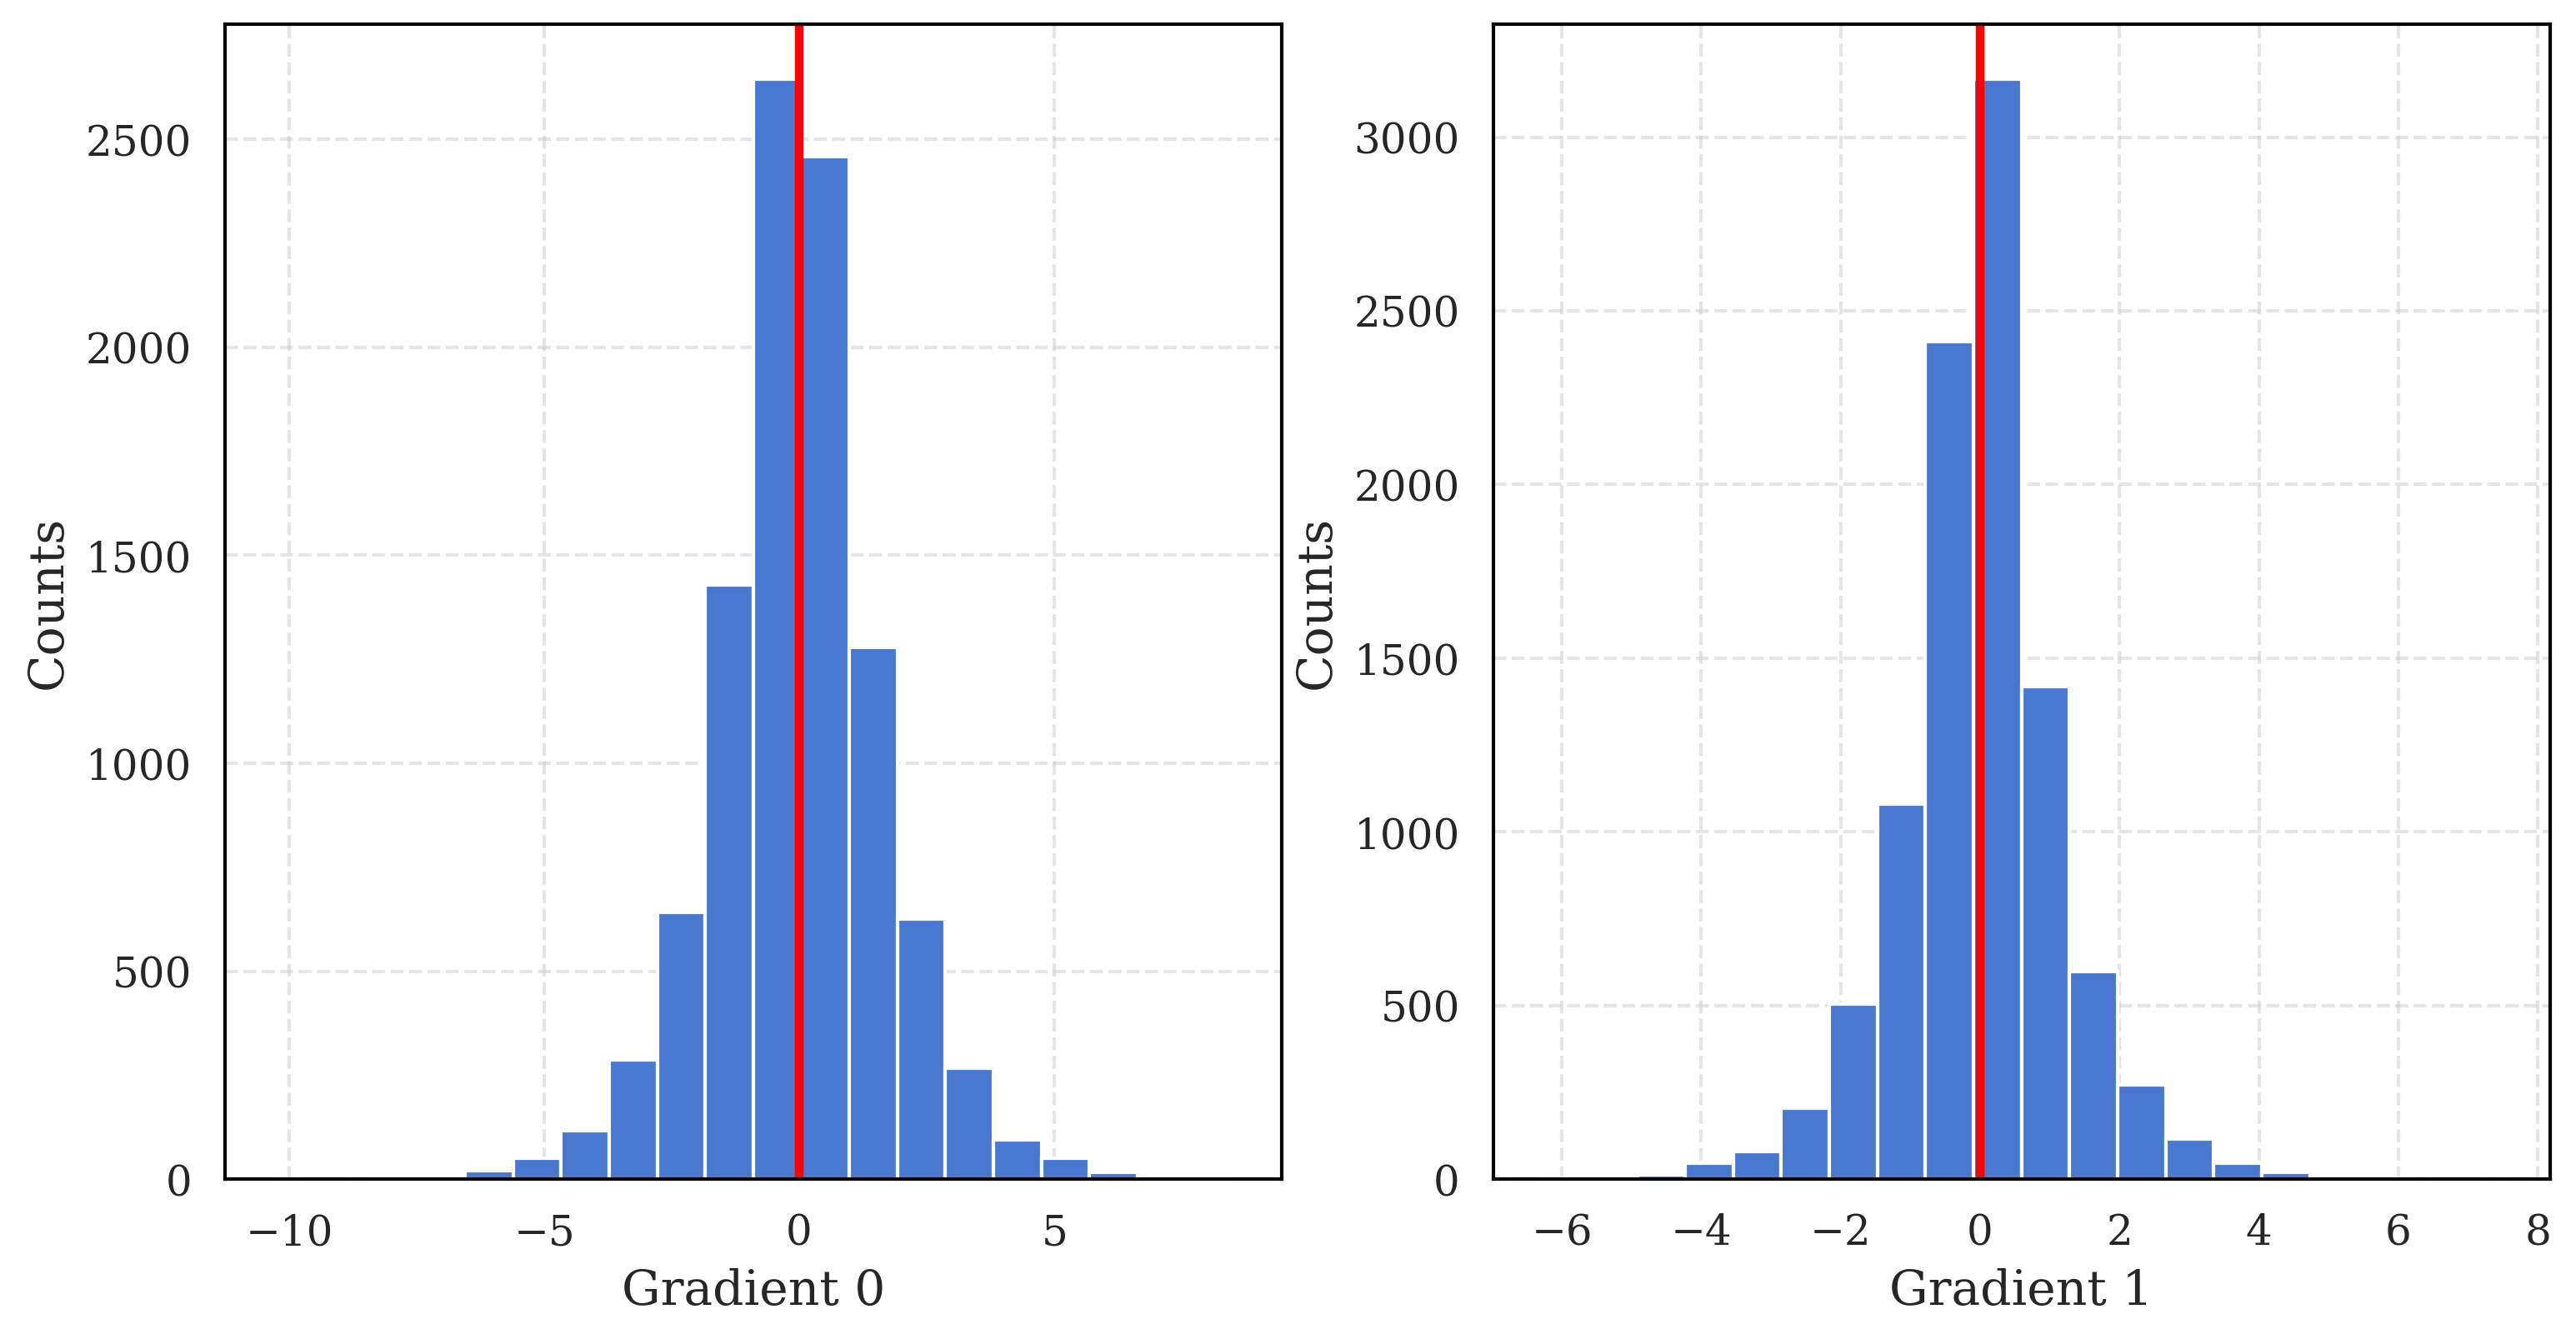

In [8]:
grads = []
for it in range(10000): 
    grads.append(-mlmc_gradient_estimator(appd.sample(), x_adv, 10, model))

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=20)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_xlabel(f'Gradient {i}')
    axs[i].set_ylabel('Counts')

Early stopping at iteration 40


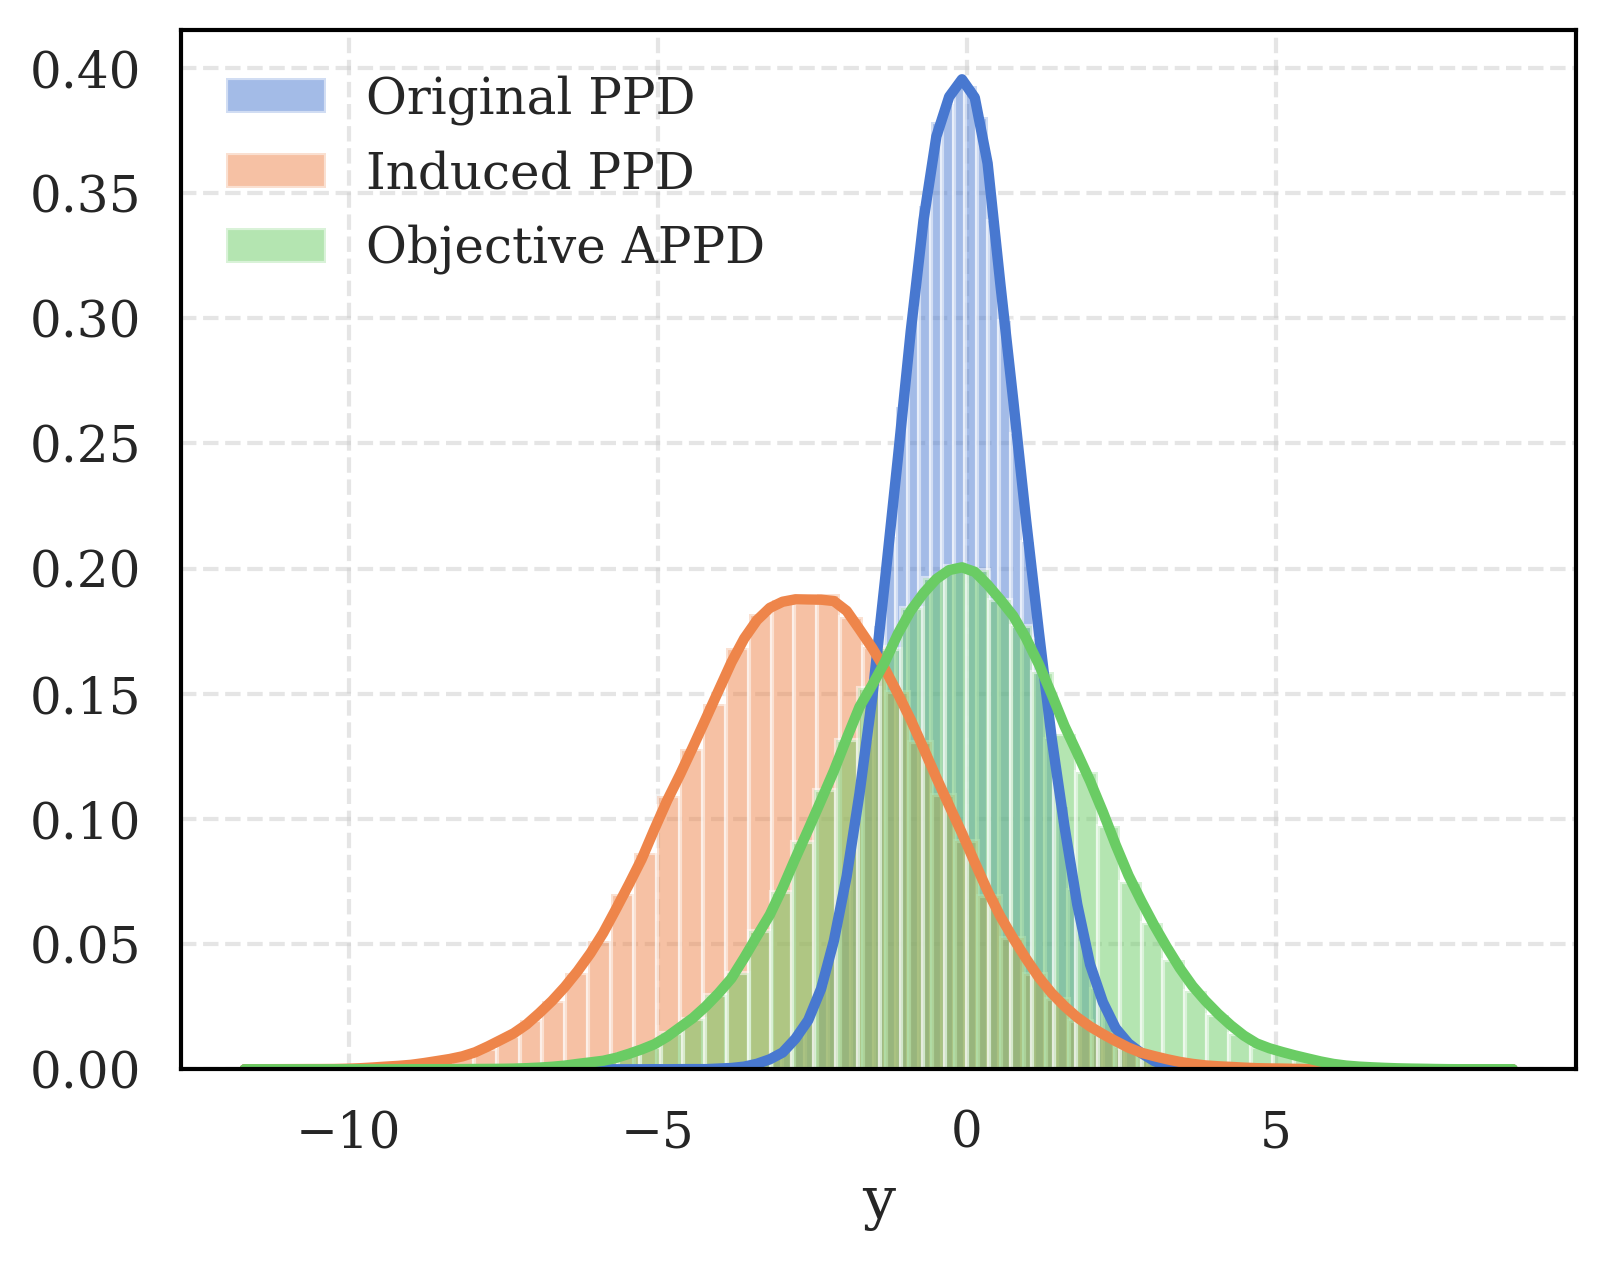

In [9]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=.1, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

In [10]:
# Vector field of perturbations
def compute_perturbation(i):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    std = model.sample_predictive_distribution(x, 10000).std()
    appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)
    x_adv, x_adv_values = mlmc_attack(model, x, appd, R=10, lr=0.01, n_iter=400)
    return x_adv.clone().detach().numpy() - x.clone().detach().numpy()

perturbations = Parallel(n_jobs=-1)(delayed(compute_perturbation)(i) for i in range(X_test.shape[0]))

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=20, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Early stopping at iteration 34
Early stopping at iteration 50


Process LokyProcess-2:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/advReg/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/advReg/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py", line 478, in _process_worker
    _process_reference_size = _get_memory_usage(pid, force_gc=True)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py", line 109, in _get_memory_usage
    gc.collect()
KeyboardInterrupt


KeyboardInterrupt: 

<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_35222/2636121568.py:35: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 54
Early stopping at iteration 68
Early stopping at iteration 107
Early stopping at iteration 168
Early stopping at iteration 203
Early stopping at iteration 375
Early stopping at iteration 385
Early stopping at iteration 416
Early stopping at iteration 485
Early stopping at iteration 529
Early stopping at iteration 605
Early stopping at iteration 426
Early stopping at iteration 728
Early stopping at iteration 835
Early stopping at iteration 712
Early stopping at iteration 935
Early stopping at iteration 905
Early stopping at iteration 12
Early stopping at iteration 22
Early stopping at iteration 60
Early stopping at iteration 72
Early stopping at iteration 109
Early stopping at iteration 204
Early stopping at iteration 242
Early stopping at iteration 253
Early stopping at iteration 257
Early stopping at iteration 326
Early stopping at iteration 454
Early stopping at iteration 455
Early stopping a

Text(0, 0.5, 'KL Divergence')

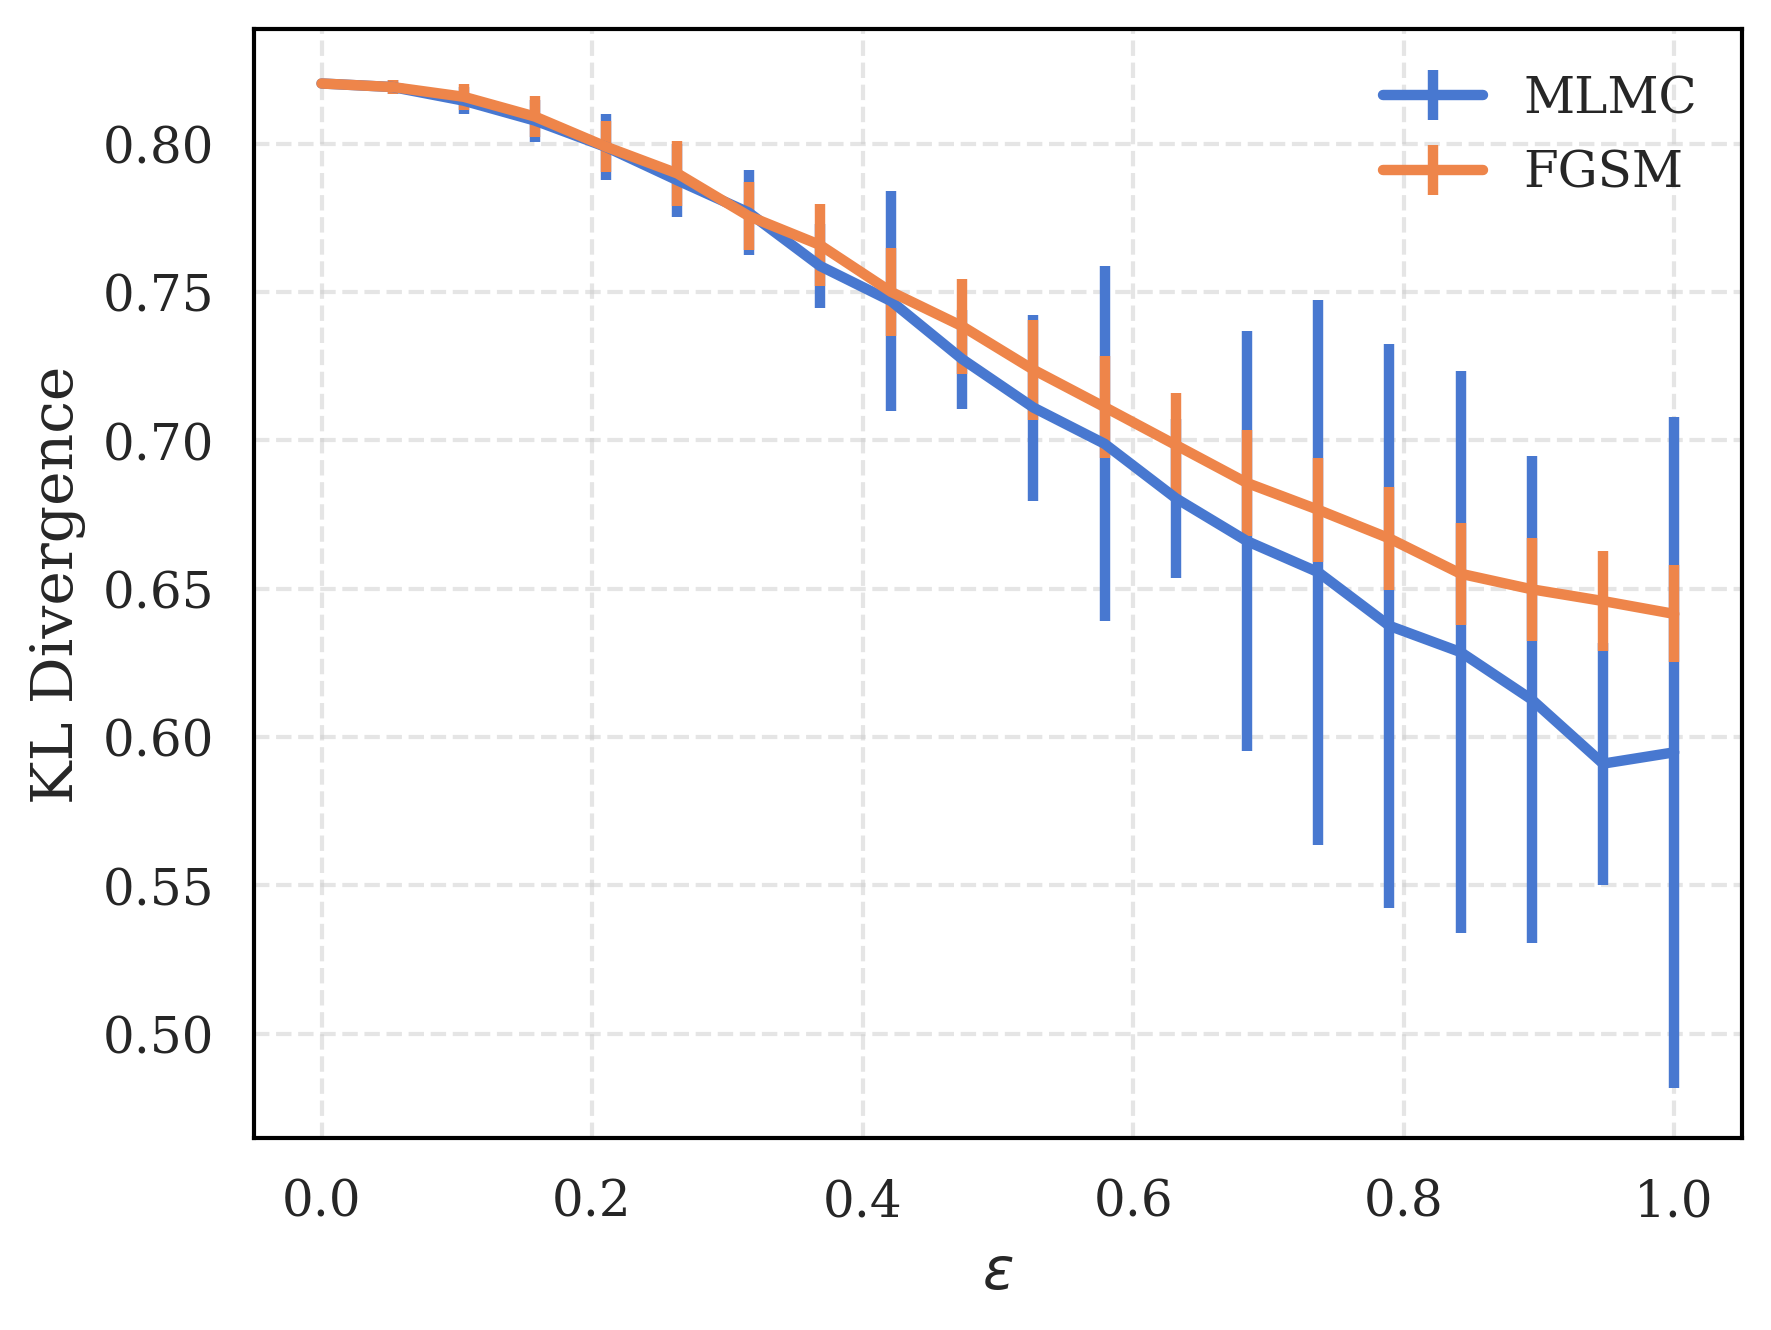

In [ ]:
# plot KL divergence as a function of the strength of the attack
n_jobs = -1
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=1000)
    kl = kl_to_appd(model.mu, model.lam, model.sigma2, x_adv_distr, x.T @ model.mu, 4 * std ** 2).item()
    x_fsgm = fgsm_attack(model, x, appd, epsilon=epsilon, R=100)
    kl_fsgm = kl_to_appd(model.mu, model.lam, model.sigma2, x_fsgm, x.T @ model.mu, 4 * std ** 2).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(20):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), yerr=2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), label='MLMC')
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_35222/3111683802.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


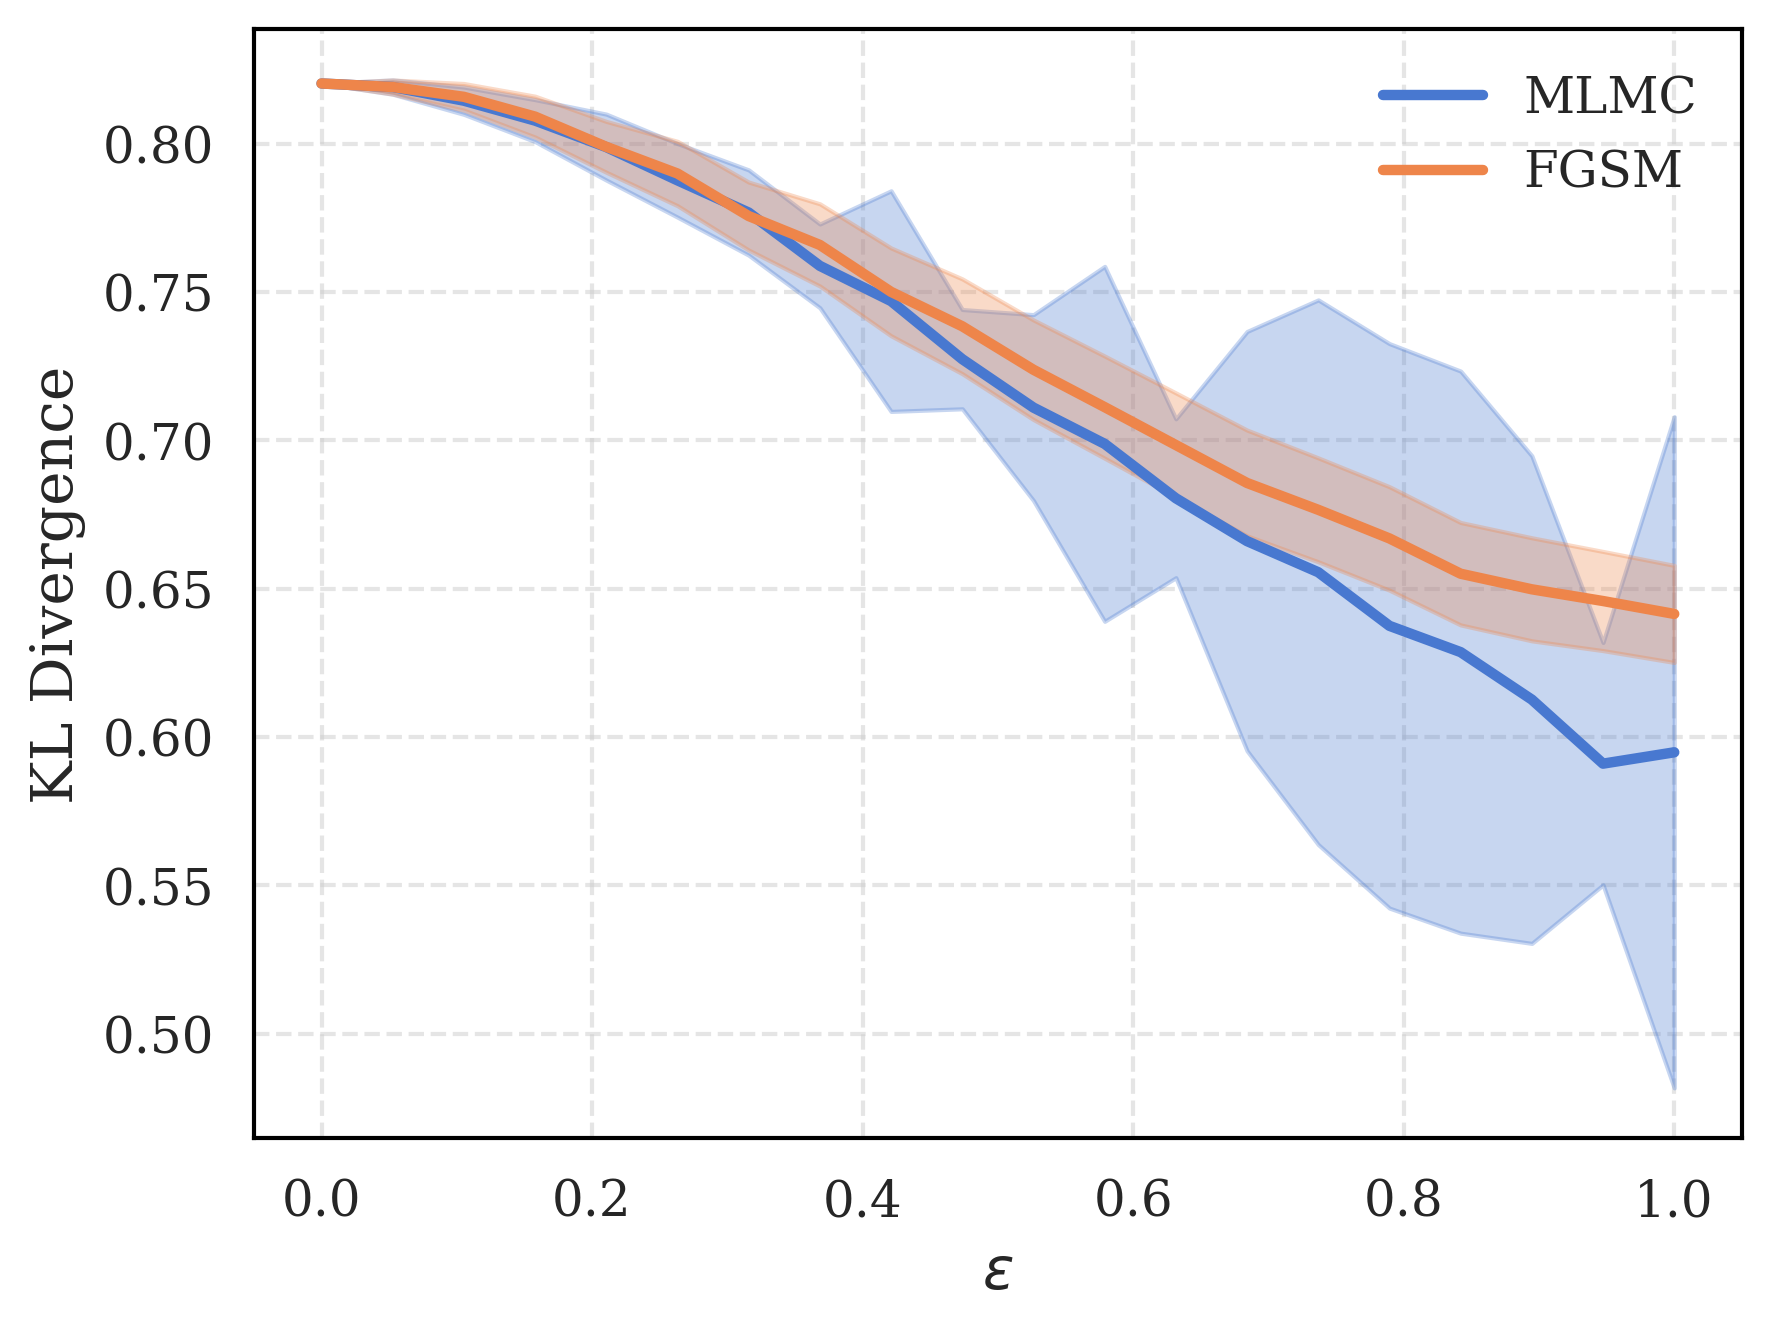

In [ ]:
plt.plot(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), color='C0', label='MLMC')
plt.fill_between(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)) - 2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)),
                    np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)) + 2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), color='C0', alpha=0.3)
plt.plot(epsilons, np.mean(kl_fsgm, axis=0, where=~np.isnan(kl_fsgm)), color='C1', label='FGSM')
plt.fill_between(epsilons, np.mean(kl_fsgm, axis=0, where=~np.isnan(kl_fsgm)) - 2*np.std(kl_fsgm, axis=0, where=~np.isnan(kl_fsgm)),
                    np.mean(kl_fsgm, axis=0, where=~np.isnan(kl_fsgm)) + 2*np.std(kl_fsgm, axis=0, where=~np.isnan(kl_fsgm)), color='C1', alpha=0.3)
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.legend()

## APPD = N(2+mu, 2*sigma)

In [ ]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=0.1, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

In [ ]:
# Vector field of perturbations
def compute_perturbation(i):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    std = model.sample_predictive_distribution(x, 10000).std()
    appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)
    x_adv, x_adv_values = mlmc_attack(model, x, appd, R=10, lr=0.01, n_iter=400)
    return x_adv.clone().detach().numpy() - x.clone().detach().numpy()

perturbations = Parallel(n_jobs=-1)(delayed(compute_perturbation)(i) for i in range(X_test.shape[0]))

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=20, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) - max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) - min(np.array(perturbations)[:,1]) - .1,max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

In [ ]:
# plot KL divergence as a function of the strength of the attack 
n_jobs = -1
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=1000)
    kl = kl_to_appd(model.mu, model.lam, model.sigma2, x_adv_distr, 2 + x.T @ model.mu, 4 * std ** 2).item()
    x_fsgm = fgsm_attack(model, x, appd, epsilon=epsilon, R=10)
    kl_fsgm = kl_to_appd(model.mu, model.lam, model.sigma2, x_fsgm, 2 + x.T @ model.mu, 4 * std ** 2).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(20):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    #kl_values = [compute_kl_divergence(epsilon) for epsilon in epsilons]
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), yerr=2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

## Maximum disruption problem

In [ ]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = x.clone().detach().requires_grad_(True)  
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

In [ ]:
grads = []
for it in range(1000):  # TODO: change to 10000
    y = model.sample_predictive_distribution(x, num_samples=1)
    grads.append(mlmc_gradient_estimator(y, x_adv, 10, model))

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=20)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_xlabel(f'Gradient {i}')
    axs[i].set_ylabel('Counts')

In [ ]:
# Vector field of perturbations
perturbations = []

for i in range(X_test.shape[0]):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    x_adv, x_adv_values = mlmc_attack(model, x, R=10, lr=0.01)
    perturbations.append(x_adv.clone().detach().numpy() - x.clone().detach().numpy())

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=20, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

In [ ]:
# plot KL divergence as a function of the strength of the attack 
n_jobs = 66

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=10)
    kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv_distr).item()
    x_fsgm = fgsm_attack(model, x, epsilon=epsilon, R=10)
    kl_fsgm = kl_div(model.mu, model.lam, model.sigma2, x, x_fsgm).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')